In [1]:
using RxInfer, Distributions, StableRNGs, Plots, Flux, CCMP

  ** incremental compilation may be fatally broken for this module **



In [2]:
function generate_data(f, g, n; seed = 123, x_i_min = -20.0, w_i_min = 20.0, noise = 5000.0, real_x_τ = 0.1, real_w_τ = 1.0)

    rng = StableRNG(seed)

    real_x = Vector{Float64}(undef, n)
    real_w = Vector{Float64}(undef, n)
    real_f = Vector{Float64}(undef, n)
    real_g = Vector{Float64}(undef, n)
    real_y = Vector{Float64}(undef, n)

    for i in 1:n
        real_x[i] = rand(rng, Normal(x_i_min, sqrt(1.0 / real_x_τ)))
        real_w[i] = rand(rng, Normal(w_i_min, sqrt(1.0 / real_w_τ)))
        real_f[i] = f(real_x[i], real_w[i])
        real_g[i] = g(real_f[i])
        real_y[i] = rand(rng, Normal(real_g[i], sqrt(noise)))

        x_i_min = real_x[i]
        w_i_min = real_w[i]
    end
    
    return real_x, real_w, real_f, real_g, real_y
end

generate_data (generic function with 1 method)

In [3]:
function smooth_min(x, y)    
    if x < y
        return x + 1e-5 * y
    else
        return y + 1e-5 * x
    end
end

function square(x)
    return (ref_point - x)^2
end

square (generic function with 1 method)

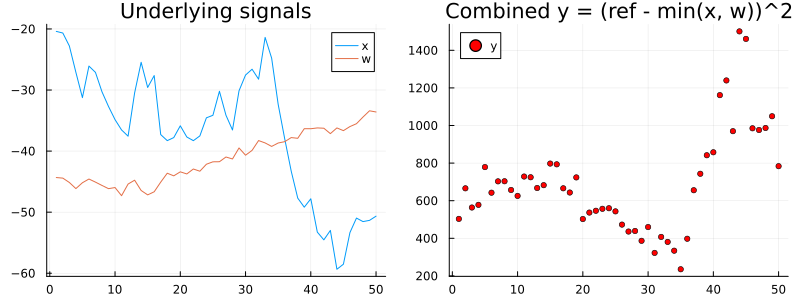

In [4]:
n = 50
ref_point = -20

x_i_min, w_i_min = -20, -45
real_x, real_w, real_f, real_g, real_y = generate_data(min, (x) -> (x - ref_point)^2 , n, x_i_min = x_i_min, w_i_min = w_i_min);

pl = plot(title = "Underlying signals")
pl = plot!(pl, real_x, label = "x")
pl = plot!(pl, real_w, label = "w")

pr = plot(title = "Combined y = (ref - min(x, w))^2")
pr = scatter!(pr, real_y, ms = 3, color = :red, label = "y")

plot(pl, pr, size = (800, 300))

In [5]:
@model function identification_problem(f, g, n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y)
    
    x0 ~ Normal(mean = m_x_0, precision = τ_x_0)
    τ_x ~ Gamma(shape = a_x, rate = b_x)
    w0 ~ Normal(mean = m_w_0, precision = τ_w_0)
    τ_w ~ Gamma(shape = a_w, rate = b_w)
    τ_y ~ Gamma(shape = a_y, rate = b_y)
    
    x = randomvar(n)
    w = randomvar(n)
    s = randomvar(n)
    t = randomvar(n)
    y = datavar(Float64, n)
    
    x_i_min = x0
    w_i_min = w0
    
    for i in 1:n
        x[i] ~ Normal(mean = x_i_min, precision = τ_x)
        w[i] ~ Normal(mean = w_i_min, precision = τ_w)
        s[i] ~ f(x[i], w[i])
        t[i] ~ g(s[i])
        y[i] ~ Normal(mean = t[i], precision = τ_y)
        x_i_min = x[i]
        w_i_min = w[i]
    end
    
end

constraints = @constraints begin 
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s, t) = q(x, x0, w, w0, s, t)q(τ_w)q(τ_x)q(τ_y)
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s, t) = q(x, x0, w, w0, s, t)q(τ_w)q(τ_x)q(τ_y)
Options:
  warn = true


In [6]:
# Smoothed version of `min` without zero-ed derivatives
linearization_meta = @meta begin 
    # In this example we are going to use a simple `Linearization` method
    smooth_min() -> Linearization()
    square() -> Linearization()
end

Meta specification:
  smooth_min() -> Linearization()
  square() -> Linearization()
Options:
  warn = true

In [7]:
m_x_0, τ_x_0 = x_i_min, 100.0
m_w_0, τ_w_0 = w_i_min, 100.0

# We set relatively strong priors for random walk noise components
# and sort of vague prior for the noise of the observations
a_x, b_x = 0.01, 0.01var(real_x)
a_w, b_w = 0.01, 0.01var(real_w)
a_y, b_y = 1.0, 1.0

# We set relatively strong priors for messages
xinit = map(r -> NormalMeanPrecision(r, τ_x_0), reverse(range(-60, -20, length = n)))
winit = map(r -> NormalMeanPrecision(r, τ_w_0), range(-40, -20, length = n))

imessages = (x = xinit, w = winit)
imarginals = (τ_x = GammaShapeRate(a_x, b_x), τ_w = GammaShapeRate(a_w, b_w), τ_y = GammaShapeRate(a_y, b_y))

result = inference(
    model = identification_problem(smooth_min, square, n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y),
    meta = linearization_meta,
    data  = (y = real_y,), 
    options = (limit_stack_depth = 500, ), 
    constraints = constraints, 
    initmessages = imessages, 
    initmarginals = imarginals, 
    iterations = 100,
)

Inference results:
  Posteriors       | available for (τ_y, w, x0, x, s, τ_x, t, τ_w, w0)


In [8]:
τ_x_marginals = result.posteriors[:τ_x]
τ_w_marginals = result.posteriors[:τ_w]
τ_y_marginals = result.posteriors[:τ_y]

tmarginals = result.posteriors[:t]
smarginals = result.posteriors[:s]
xmarginals = result.posteriors[:x]
wmarginals = result.posteriors[:w];

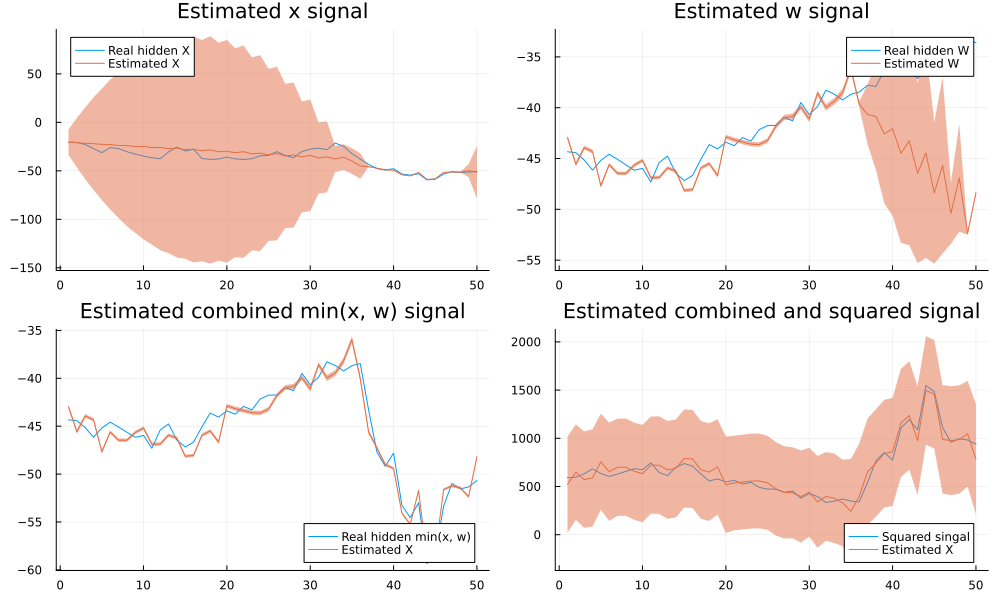

In [9]:
pxx = plot(legend = :topleft, title = "Estimated x signal")
pxw = plot(legend = :topright, title = "Estimated w signal")
pxs = plot(legend = :bottomright, title = "Estimated combined min(x, w) signal")
pxt = plot(legend = :bottomright, title = "Estimated combined and squared signal")

pxx = plot!(pxx, real_x, label = "Real hidden X")
pxx = plot!(pxx, mean.(xmarginals[end]), ribbon = var.(xmarginals[end]), label = "Estimated X")

pxw = plot!(pxw, real_w, label = "Real hidden W")
pxw = plot!(pxw, mean.(wmarginals[end]), ribbon = [min(var, 100) for var in var.(wmarginals[end])], label = "Estimated W")

pxs = plot!(pxs, real_f, label = "Real hidden min(x, w)")
pxs = plot!(pxs, mean.(smarginals[end]), ribbon = var.(smarginals[end]), label = "Estimated X")

pxt = plot!(pxt, real_g, label = "Squared singal")
pxt = plot!(pxt, mean.(tmarginals[end]), ribbon = var.(tmarginals[end]), label = "Estimated X")

plot(pxx, pxw, pxs, pxt, size = (1000, 600))